In [4]:
# Importing Libraries:

import pandas as pd
import numpy as np
from scipy.stats import shapiro
from scipy.stats import ranksums, pointbiserialr

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold, cross_validate
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV

In [5]:
# Importing data:

df_raw = pd.read_csv("KAG_energydata_complete.csv")

In [6]:
# Creating a copy of the dataset:

df = df_raw.copy()

In [7]:
# Shape of the dataset:

print(f"Shape: {df.shape}")

Shape: (19735, 29)


In [8]:
# Looking at the first five lines: 

df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


## 1) Data Munging

#### 1.1) Data Cleaning

First let's see if there are missing data in the dataset.

In [9]:
# Looking for missing data:

df.isna().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

Looking for wrong variable type

In [10]:
# Information about data types:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [11]:
# Changing date's type to datetime:

df['date'] = pd.to_datetime(df['date'])
df.dtypes

date           datetime64[ns]
Appliances              int64
lights                  int64
T1                    float64
RH_1                  float64
T2                    float64
RH_2                  float64
T3                    float64
RH_3                  float64
T4                    float64
RH_4                  float64
T5                    float64
RH_5                  float64
T6                    float64
RH_6                  float64
T7                    float64
RH_7                  float64
T8                    float64
RH_8                  float64
T9                    float64
RH_9                  float64
T_out                 float64
Press_mm_hg           float64
RH_out                float64
Windspeed             float64
Visibility            float64
Tdewpoint             float64
rv1                   float64
rv2                   float64
dtype: object

In [12]:
# Setting date as the index

df.set_index('date', inplace=True)

#### 1.2) Exploratory Data Analisys

In [13]:
# Separating columns

temperature_column = [i for i in df.columns if "T" in i]
humidity_column = [i for i in df.columns if "RH" in i]
other = [i for i in df.columns if ("T" not in i)&("RH" not in i)]

In [14]:
# Humidity statistics:

df[humidity_column].describe()

,RH_1,RH_2,RH_3,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9,RH_out
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,40.259739,40.420420,39.242500,39.026904,50.949283,54.609083,35.388200,42.936165,41.552401,79.750418
std,3.979299,4.069813,3.254576,4.341321,9.022034,31.149806,5.114208,5.224361,4.151497,14.901088
min,27.023333,20.463333,28.766667,27.660000,29.815000,1.000000,23.200000,29.600000,29.166667,24.000000
25%,37.333333,37.900000,36.900000,35.530000,45.400000,30.025000,31.500000,39.066667,38.500000,70.333333
50%,39.656667,40.500000,38.530000,38.400000,49.090000,55.290000,34.863333,42.375000,40.900000,83.666667
75%,43.066667,43.260000,41.760000,42.156667,53.663333,83.226667,39.000000,46.536000,44.338095,91.666667
max,63.360000,56.026667,50.163333,51.090000,96.321667,99.900000,51.400000,58.780000,53.326667,100.000000


In [15]:
# Temperature statistics:

df[temperature_column].describe()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T_out,Tdewpoint
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,20.341219,22.267611,20.855335,19.592106,7.910939,20.267106,22.029107,19.485828,7.411665,3.760707
std,1.606066,2.192974,2.006111,2.042884,1.844623,6.090347,2.109993,1.956162,2.014712,5.317409,4.194648
min,16.790000,16.100000,17.200000,15.100000,15.330000,-6.065000,15.390000,16.306667,14.890000,-5.000000,-6.600000
25%,20.760000,18.790000,20.790000,19.530000,18.277500,3.626667,18.700000,20.790000,18.000000,3.666667,0.900000
50%,21.600000,20.000000,22.100000,20.666667,19.390000,7.300000,20.033333,22.100000,19.390000,6.916667,3.433333
75%,22.600000,21.500000,23.290000,22.100000,20.619643,11.256000,21.600000,23.390000,20.600000,10.408333,6.566667
max,26.260000,29.856667,29.236000,26.200000,25.795000,28.290000,26.000000,27.230000,24.500000,26.100000,15.500000


In [16]:
# Other column statistics:

df[other].describe()

,Appliances,lights,Press_mm_hg,Windspeed,Visibility,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,755.522602,4.039752,38.330834,24.988033,24.988033
std,102.524891,7.935988,7.399441,2.451221,11.794719,14.496634,14.496634
min,10.000000,0.000000,729.300000,0.000000,1.000000,0.005322,0.005322
25%,50.000000,0.000000,750.933333,2.000000,29.000000,12.497889,12.497889
50%,60.000000,0.000000,756.100000,3.666667,40.000000,24.897653,24.897653
75%,100.000000,0.000000,760.933333,5.500000,40.000000,37.583769,37.583769
max,1080.000000,70.000000,772.300000,14.000000,66.000000,49.996530,49.996530


The first, second and third quartiles are 0 for the lights column, which means that most of the information of this column is 0. As we can see below more than 77% of the registers in this column is 0 and so, not relevant to the prediction.

In [17]:
# Counting values of the "lights" column:

df['lights'].value_counts(normalize=True)

lights
0     0.772840
10    0.112085
20    0.082290
30    0.028325
40    0.003902
50    0.000456
70    0.000051
60    0.000051
Name: proportion, dtype: float64

In [18]:
# Dropping the lights column:

df.drop(columns='lights', inplace=True)

Outliers

Looking at the statistics of "other" columns, we can see that there are some outliers in Visibility, Windspeed and Appliance. Let's plot a box plot of each one of those and see the outliers closer.

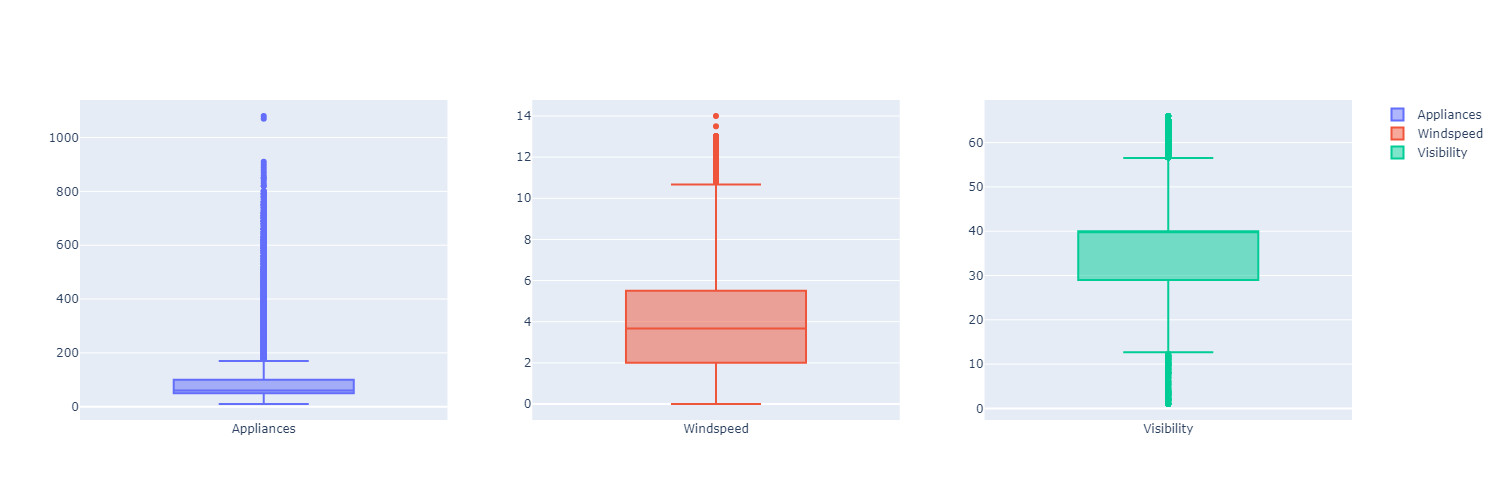

In [19]:
# Using boxplot on Visibility, Appliances and Windspeed to visualize the outliers:

fig_sub = make_subplots(rows=1, cols=3, shared_yaxes=False)

fig_sub.add_trace(

    go.Box(y=df['Appliances'].values,
           name='Appliances'
           ),
    row=1, col=1

)

fig_sub.add_trace(
    go.Box(y=df['Windspeed'].values,
           name='Windspeed'
           ),
    row=1, col=2
)

fig_sub.add_trace(
    go.Box(y=df['Visibility'].values,
           name='Visibility'
           ),
    row=1, col=3
)

fig_sub.show("png",width=1500, height=500)

Distributions

A quick way to have an idea about a varibable distribution is plotting a histogram.

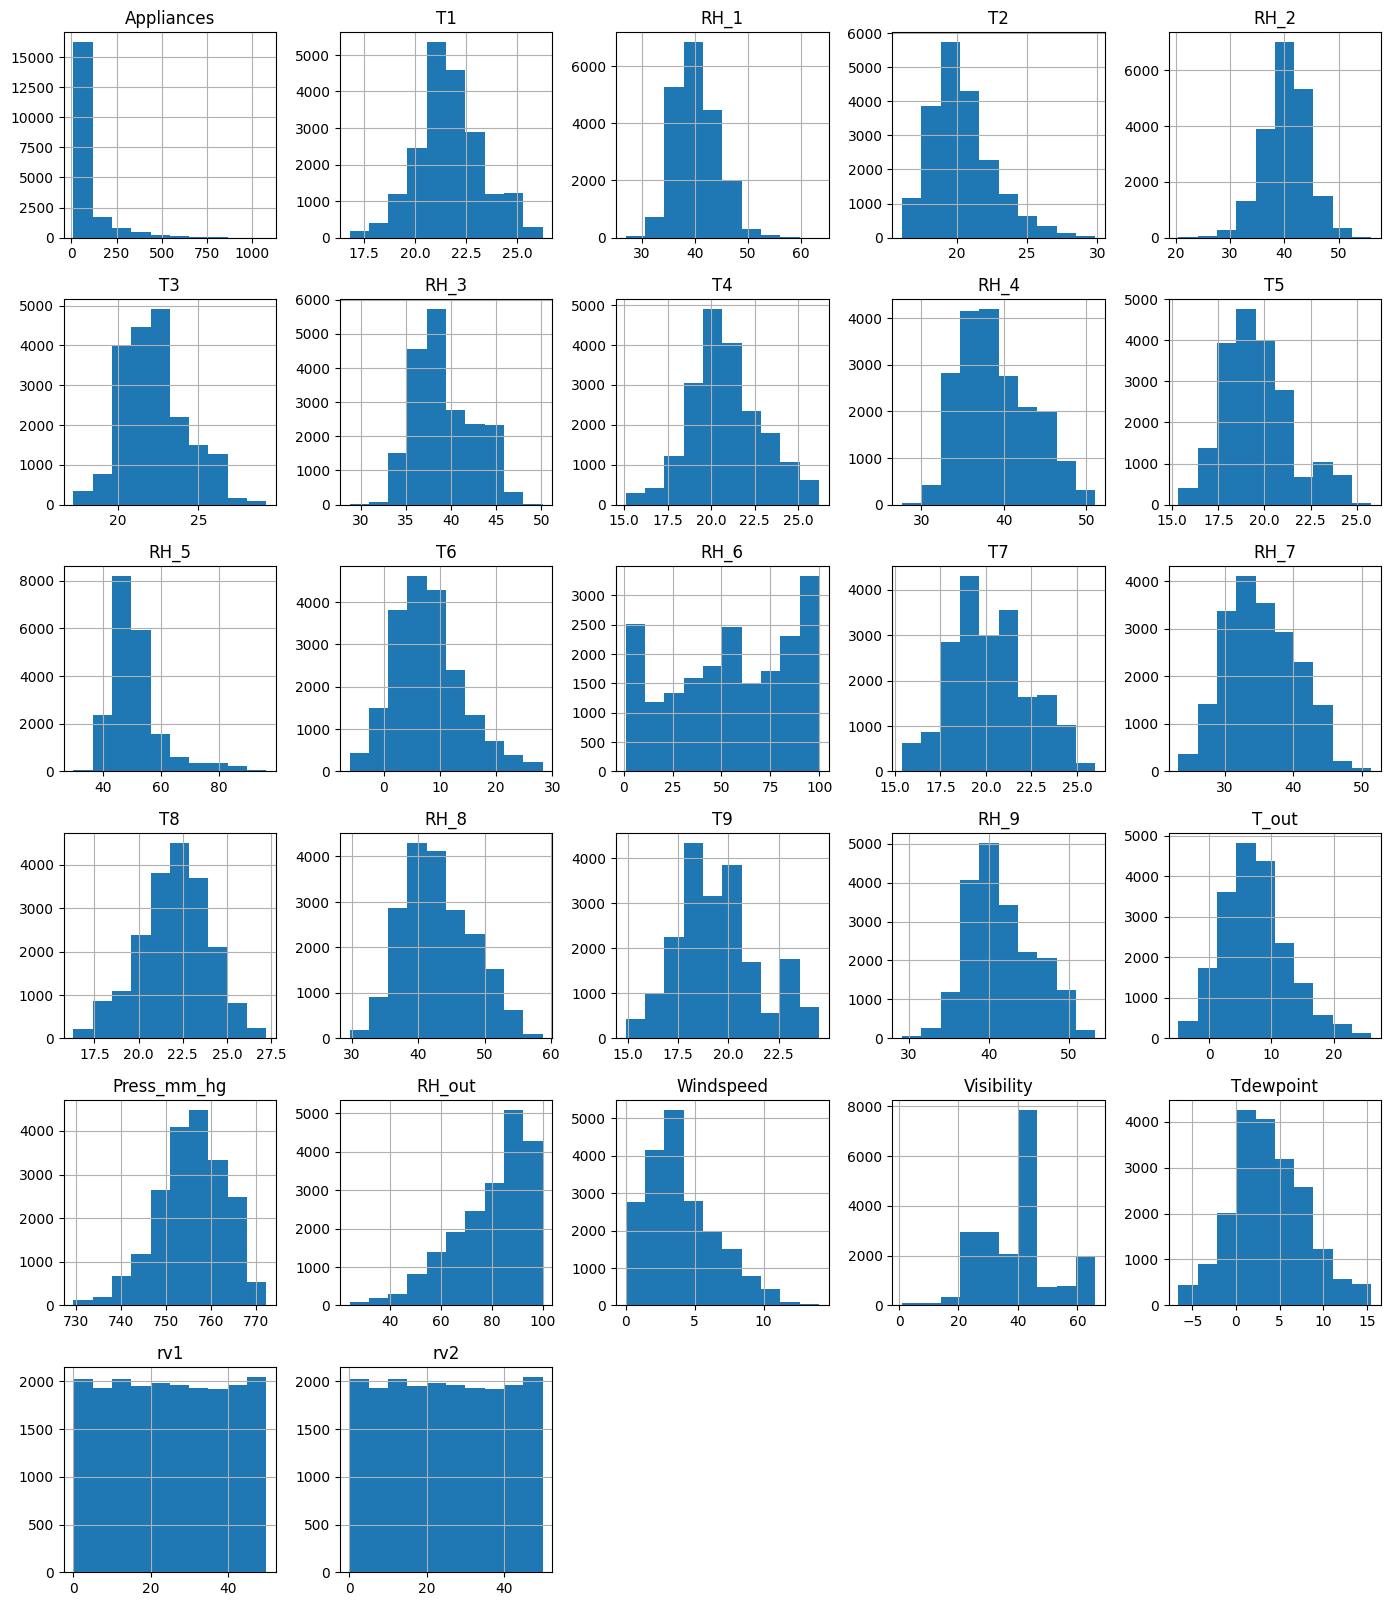

In [20]:
# Visualizing distributions using Histograms:

df.hist(figsize=(17, 20));

We will use a test statistic named Shapiro to evaluate normallity.

Obs:

1 - If p-value is smaller than 0.05, we can not assume a normal distribution.

2 - If p-value is larger than 0.05, we can assume a normal distribution.

3 - For datasets larger than 5000 samples, the p-value will be an approximation.

 

In [21]:
# Extracting a random sample of 5000 registers from our dataset:

df_sampled = df.sample(n=5000, random_state=42)


# Using Shapiro test for normallity evaluation:

for c in df.columns:
    w_statisc, p_values = shapiro(df_sampled[c])
    print(f'Test for {c}: (statistic={w_statisc}, p-value={p_values})')

Test for Appliances: (statistic=0.5849369764328003, p-value=0.0)
Test for T1: (statistic=0.9911403059959412, p-value=3.733412196820106e-17)
Test for RH_1: (statistic=0.9821624159812927, p-value=1.2745344613958403e-24)
Test for T2: (statistic=0.9549137353897095, p-value=9.466583207000185e-37)
Test for RH_2: (statistic=0.9911195039749146, p-value=3.5440305190650705e-17)
Test for T3: (statistic=0.980573832988739, p-value=1.2472995316811506e-25)
Test for RH_3: (statistic=0.9624248743057251, p-value=3.6429414818547343e-34)
Test for T4: (statistic=0.9901070594787598, p-value=3.099034646471756e-18)
Test for RH_4: (statistic=0.9676409363746643, p-value=4.054767846141661e-32)
Test for T5: (statistic=0.9707837700843811, p-value=9.308487738172878e-31)
Test for RH_5: (statistic=0.8472362160682678, p-value=0.0)
Test for T6: (statistic=0.9771420359611511, p-value=1.2924734819367967e-27)
Test for RH_6: (statistic=0.9391845464706421, p-value=3.284923860070236e-41)
Test for T7: (statistic=0.98504507541

Correlations

We will use Pearson's correlarion due to the type and nature of the variables (numeric target and features)

In [22]:
# Function to plot heatmap of correlations:

def plot_correlation(dataframe):
    correlations=dataframe.corr()

    mask =  np.zeros_like(correlations)
    mask[np.triu_indices_from(mask)] = True


    plt.figure(figsize=(27, 10))
    sns.heatmap(correlations, annot=True, mask=mask, cmap="crest");


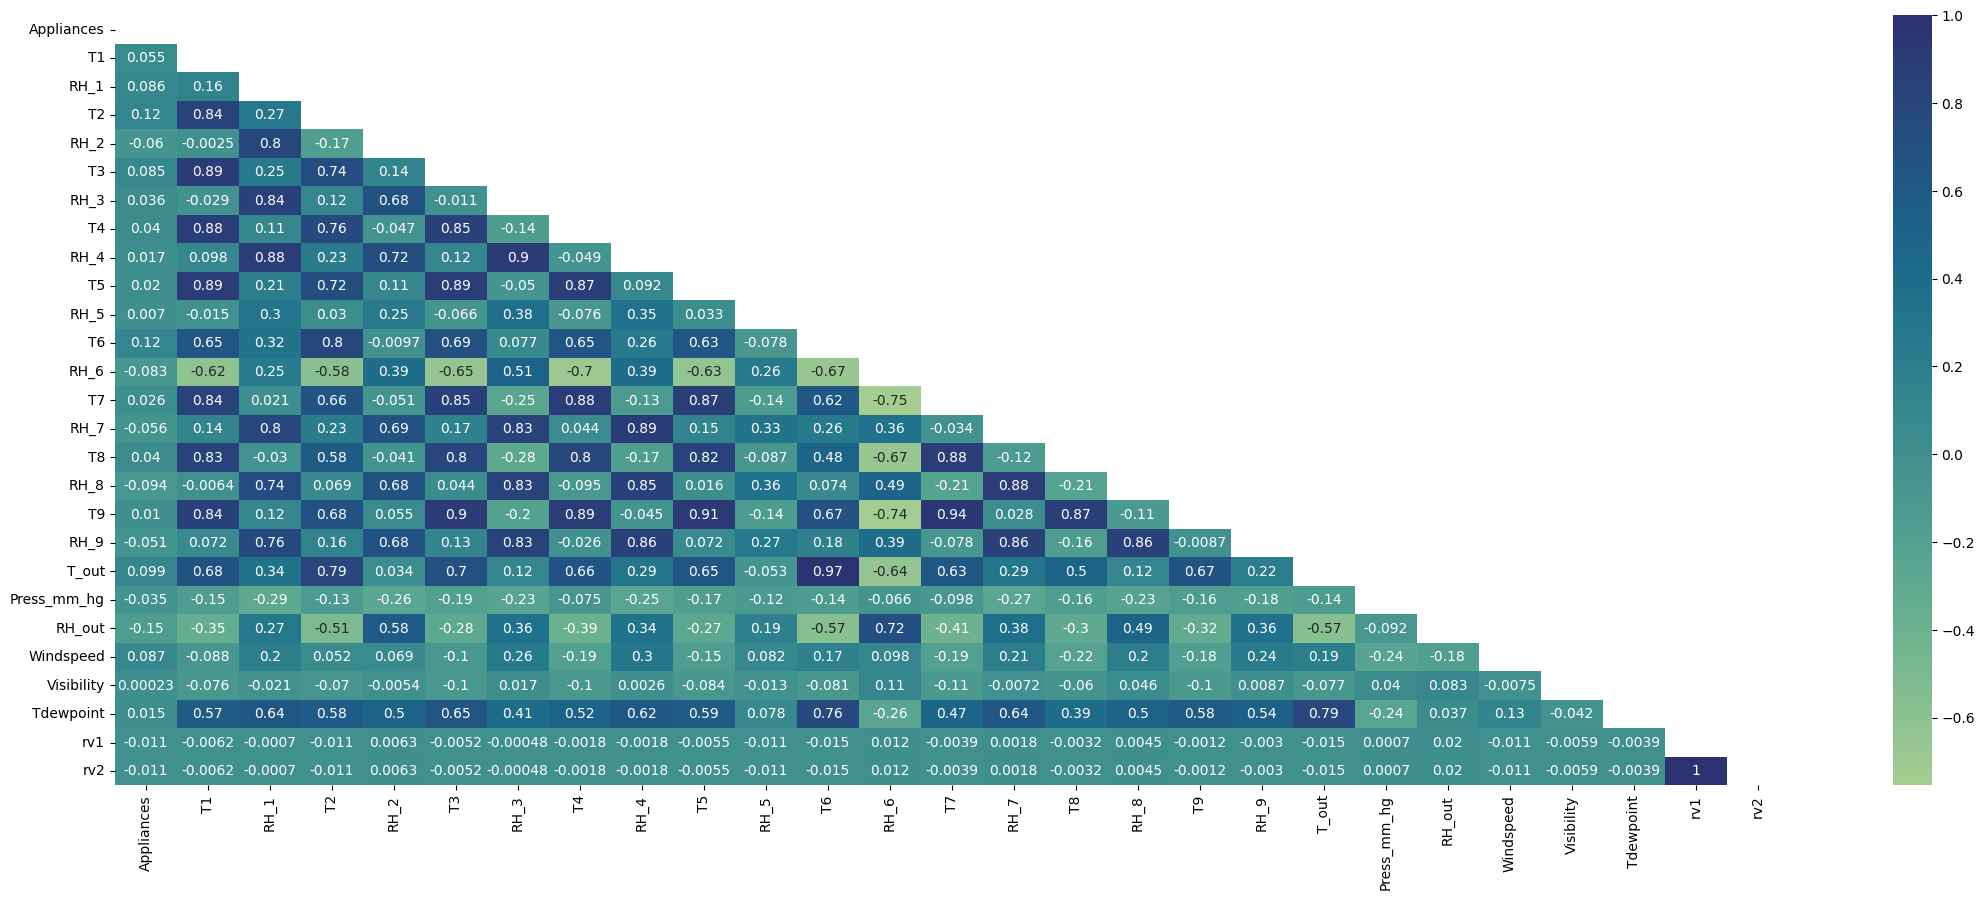

In [23]:
# Plotting a Heatmap with all the correlations:

plot_correlation(df)

Conclusions

1 - As a result of the Shapiro test, no feature follows a normal distribution (p-value less than 0.05).

2 - T6 and T_out are highly correlated(0.97), probably because they both were measured outside the building.

3 - All Temperatures are significant correlated to each other, but T9 has many correlations superior than 0.9 points.

4 - The two random variables are basically the same and their negative correlation with the target is close to 0, so we can exclude them both from the dataset.

## 2) Preprocessing

In [24]:
# We are going to drop some columns because of their correlation analysis:

features = df.drop(columns=['rv1', 'rv2', 'T_out', 'T9'])

#### 2.1) Feature Engineering

We will transform date column in a binary class feature that will represent weekend(1) and weekdays(0).

In [25]:
# Reset the index:

features_eng = features.reset_index()

In [26]:
# Transfoming date column in a binary class feature:

features_eng['Weekend'] = features_eng['date'].dt.dayofweek

In [27]:
# Printing the dataset

features_eng.head()

,date,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_7,T8,RH_8,RH_9,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Weekend
0,2016-01-11 17:00:00,60,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,41.626667,18.2,48.900000,45.53,733.5,92.0,7.000000,63.000000,5.3,0
1,2016-01-11 17:10:00,60,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,41.560000,18.2,48.863333,45.56,733.6,92.0,6.666667,59.166667,5.2,0
2,2016-01-11 17:20:00,50,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,41.433333,18.2,48.730000,45.50,733.7,92.0,6.333333,55.333333,5.1,0
3,2016-01-11 17:30:00,50,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,41.290000,18.1,48.590000,45.40,733.8,92.0,6.000000,51.500000,5.0,0
4,2016-01-11 17:40:00,60,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,41.230000,18.1,48.590000,45.40,733.9,92.0,5.666667,47.666667,4.9,0


In [28]:
# Before the mapping:

features_eng['Weekend'].value_counts()

Weekend
1    2880
2    2880
3    2880
4    2845
0    2778
5    2736
6    2736
Name: count, dtype: int64

In [29]:
#  Mapping the categorical variable to be either 0 or 1:

features_eng['Weekend'] = features_eng['Weekend'].apply(lambda x : 1 if (x == 6)|(x==5) else 0)
features_eng['Weekend'].value_counts()

Weekend
0    14263
1     5472
Name: count, dtype: int64

In [30]:
# Setting date as index again:

features_eng.set_index('date', inplace=True)

In [31]:
# Printing the dataset to see the changed column

features_eng.head()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_7,T8,RH_8,RH_9,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Weekend
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,41.626667,18.2,48.900000,45.53,733.5,92.0,7.000000,63.000000,5.3,0
2016-01-11 17:10:00,60,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,41.560000,18.2,48.863333,45.56,733.6,92.0,6.666667,59.166667,5.2,0
2016-01-11 17:20:00,50,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,41.433333,18.2,48.730000,45.50,733.7,92.0,6.333333,55.333333,5.1,0
2016-01-11 17:30:00,50,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,...,41.290000,18.1,48.590000,45.40,733.8,92.0,6.000000,51.500000,5.0,0
2016-01-11 17:40:00,60,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,41.230000,18.1,48.590000,45.40,733.9,92.0,5.666667,47.666667,4.9,0


##### T-test

We need to verify, using the T-Test Hypothesis, whether the new categorical fature(Weekend) has any kind of relation with de numeric target(Appliances) or not. For that, we will use two sample T-test, which means that we will test the difference between of means between two groups of our categorical feature.


- NULL Hypothesis: There is no difference between the energy consumed on weekends and weekdays.


- Alternative Hypothesis: Energy consumption on weekends is different than on weekdays.


OBS: Two sample T-test assumes that our samples came from a normal distribution, so we need to check that assumption before applying it to our data. 


In [32]:
# Sampling the groups:

weekdays = features_eng[features_eng['Weekend'] == 0].sample(n=300, random_state=42)['Appliances']
weekend = features_eng[features_eng['Weekend'] == 1].sample(n=300, random_state=42)['Appliances']

In [33]:
# Normality test:

print(f"Weekdays: {shapiro(weekdays)}")
print(f"Weekends: {shapiro(weekend)}")

Weekdays: ShapiroResult(statistic=0.5949463844299316, pvalue=6.323979251306852e-26)
Weekends: ShapiroResult(statistic=0.681671142578125, pvalue=2.1151544435960978e-23)


Since p-value for the Shapirto test was less than 0.05, we can't assume that they come from a normal distribution. Therefore, we won't use T-test to evaluate their relation.

##### Wilcoxon Rank-Sum

 As an alternative solution, we will use a non parametric test called Wilcoxon rank-sum test, which does not assume normality.

- Null Hypothesis: Two sets of measurements come from the same distribution.

- Alternative Hypothesis: Measurements in one sample tend to be larger than the values of in the other sample.

In [34]:
# Wilcoxon rank-sum statistic for two samples:

ranksums(weekend, weekdays, alternative="greater")

RanksumsResult(statistic=2.3616550407154433, pvalue=0.00909678130539973)

Since p-value is less than 0.05, we can reject the null Hypothesis and assume that the Energy consumed on Weekends are larger than the energy consumed on Weekdays.

##### Point Biserial Correlation

Now, we can quantify this relation by using the Point Biserial correlation which return a statistic metric(R value) varing between [-1, 1], that measures the correlation between these variables. Furthermore, the point bisserial also returns the p-value.

In [35]:
# We will use the Point Biserial correlation to asses whether there is a correlation between the categorical and numeric variables:

point_bisserial_cor = pointbiserialr(features_eng['Weekend'], features_eng['Appliances'])
point_bisserial_cor

SignificanceResult(statistic=0.017437050668854755, pvalue=0.014301067218672008)

Since the statistic(R value) is 0.0174, we assume that there is a positive correlation between these variables.

In [36]:
# Now, we need to separate the target from the whole dataset:

target = df["Appliances"]
features_eng.drop(columns='Appliances', inplace=True)

#### 2.2) Transformation

In [37]:
# Function used to evaluate the best algorithms:

def melhor_modelo(X_train, y_train, dicionario):

    seed = 42
    cv = 5
    score = ['neg_root_mean_squared_error', 'r2']
    result_rmse = {}
    result_r2 = {}


    for name, model in dicionario.items():
        k_fold = KFold(n_splits=cv, random_state=seed, shuffle=True)
        result = cross_validate(model, X_train, y_train, cv=k_fold, scoring=score)

        result_rmse[name] = -result['test_neg_root_mean_squared_error']
        result_r2[name] = result['test_r2']
        
        
    result_pd_rmse = pd.DataFrame(data=result_rmse)
    result_pd_r2 = pd.DataFrame(data=result_r2)
    
    return result_pd_rmse, result_pd_r2
    

In [38]:
# Dictionary of algorithms:

modelos_dicionario = {
        "Lasso":Lasso(random_state=42),
        "Ridge":Ridge(random_state=42),
        "SVR":SVR(),
        "RandomForest":RandomForestRegressor(random_state=42),
        "XGB":XGBRegressor(random_state=42),
        "MLP":MLPRegressor(random_state=42, max_iter=2500)
    }

In [39]:
# Splitting into three sets: 

X_train, X_test, y_train, y_test = train_test_split(features_eng, target, test_size=0.25, random_state=42)

In [40]:
# Printing shapes:

print("Shapes:")
print(f"X_Train set: {X_train.shape}")
print(f"y_Train set: {y_train.shape}\n")
print(f"X_Test set: {X_test.shape}")
print(f"y_Test set: {y_test.shape}")

Shapes:
X_Train set: (14801, 23)
y_Train set: (14801,)

X_Test set: (4934, 23)
y_Test set: (4934,)


In [41]:
# Numerical feature names:

numeric_columns = features_eng.drop(columns='Weekend').columns

##### 2.2.1) MinMaxScaler

In [42]:
# MinMax Scaler:

min_max_scaler = MinMaxScaler()
X_train_min_max = min_max_scaler.fit_transform(X_train[numeric_columns])
X_test_min_max = min_max_scaler.transform(X_test[numeric_columns])

In [43]:
# Concatenating with the catgorical variable:

X_train_min_max = np.concatenate([X_train_min_max, X_train['Weekend'].values.reshape([-1, 1])], axis=1)
X_test_min_max = np.concatenate([X_test_min_max, X_test['Weekend'].values.reshape([-1, 1])], axis=1)

In [44]:
# Result of the function melhor_modelo:

resultados_min_max_rmse, resultados_min_max_r2 = melhor_modelo(X_train_min_max, y_train, modelos_dicionario)

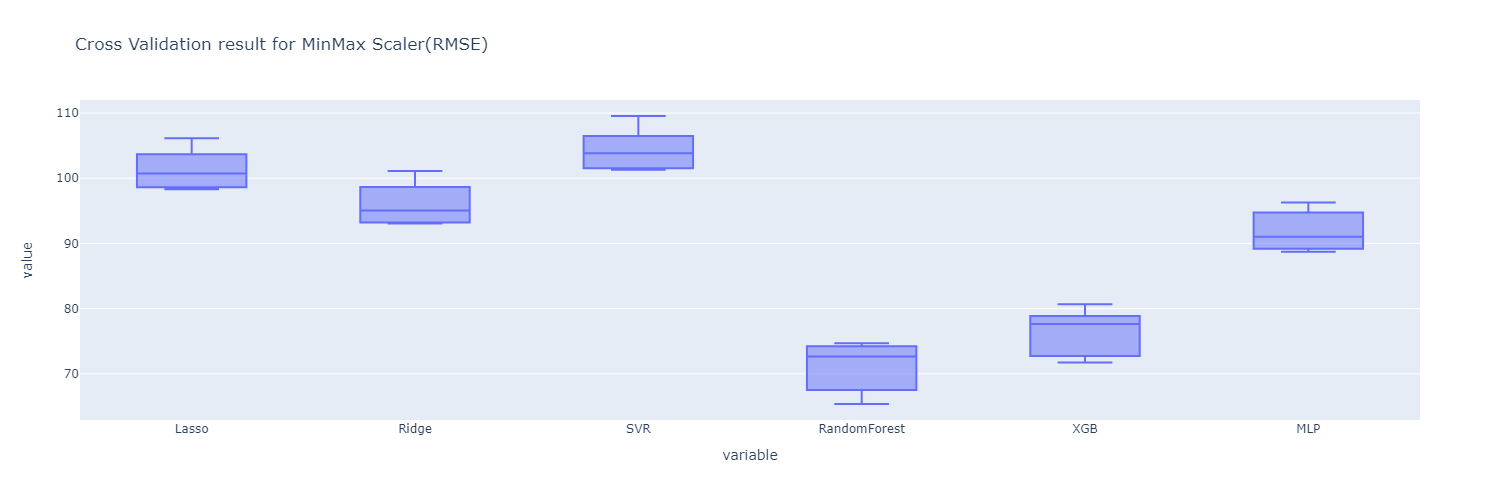

In [45]:
# Boxplot of the result for analisys of the algorithms, using MinMax Scaler:

fig = px.box(resultados_min_max_rmse, title= "Cross Validation result for MinMax Scaler(RMSE)")
fig.show("png",width=1500, height=500)

In [46]:
# Models statistics for RMSE metric, using MinMax Scaler:

resultados_min_max_rmse.describe()

,Lasso,Ridge,SVR,RandomForest,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,101.336746,96.054248,104.344491,71.005338,76.267523,91.909913
std,3.226764,3.411626,3.368996,4.041997,3.749935,3.243294
min,98.295947,93.051656,101.302954,65.365569,71.723568,88.731979
25%,98.710872,93.258726,101.585026,68.228818,73.044998,89.311399
50%,100.713914,95.036727,103.836828,72.644248,77.656365,91.004110
75%,102.847561,97.809117,105.452170,74.091992,78.241879,94.231831
max,106.115436,101.115015,109.545477,74.696061,80.670804,96.270245


In [47]:
# Models statistics for R2 metric, using MinMax Scaler: 

resultados_min_max_r2.describe()

,Lasso,Ridge,SVR,RandomForest,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.039718,0.137346,-0.018117,0.528474,0.456182,0.210146
std,0.003835,0.010486,0.005732,0.032725,0.026218,0.012148
min,0.035541,0.125444,-0.026467,0.499460,0.428566,0.190362
25%,0.036807,0.127723,-0.021680,0.499949,0.441820,0.207243
50%,0.038851,0.139656,-0.015167,0.522744,0.443341,0.215245
75%,0.043185,0.144155,-0.013927,0.542876,0.476063,0.216730
max,0.044206,0.149751,-0.013345,0.577340,0.491118,0.221151


Random Forest was the best algorithms while using the MinMax scaler.

- R2 score(mean): 0.528474
- Root mean squared error(mean): 71.005338

##### 2.2.2) StandarScaler

In [48]:
# Standard Scaler:

std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train[numeric_columns])
X_test_std = std_scaler.transform(X_test[numeric_columns])

In [49]:
# Concatenating with the catgorical variable:

X_train_std = np.concatenate([X_train_std, X_train['Weekend'].values.reshape([-1, 1])], axis=1)
X_test_std = np.concatenate([X_test_std, X_test['Weekend'].values.reshape([-1, 1])], axis=1)

In [50]:
# Result of the function melhor_modelo:

result_std_rmse, result_std_r2 = melhor_modelo(X_train_std, y_train, modelos_dicionario)

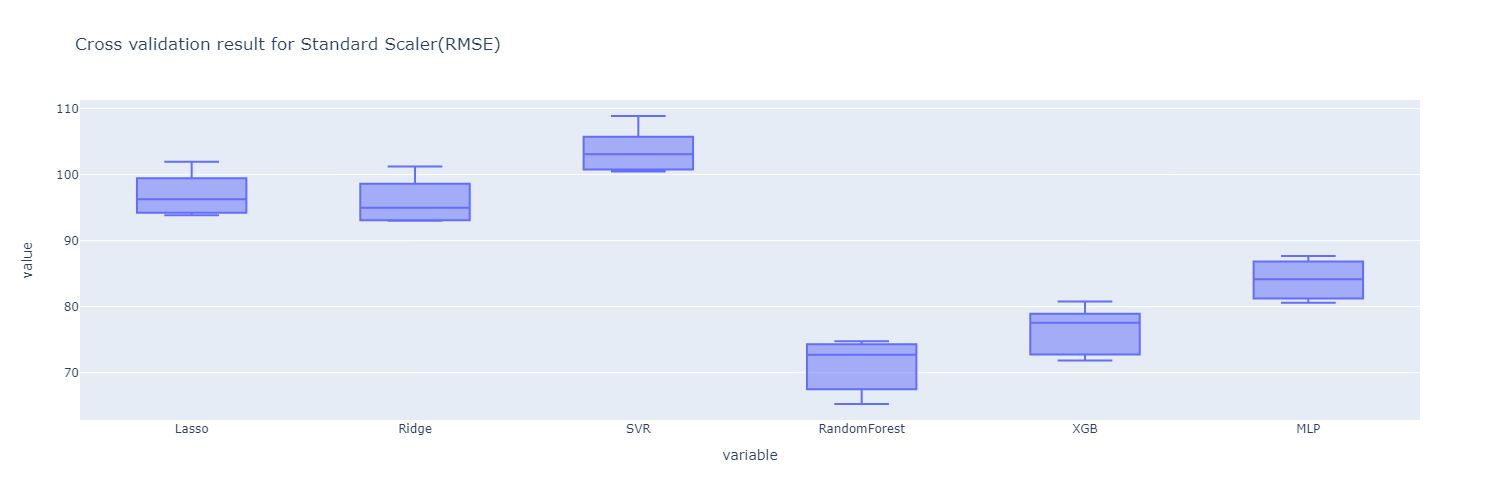

In [51]:
# Boxplot of the result for analisys of the algorithms, using Standard Scaler:

fig = px.box(result_std_rmse, title="Cross validation result for Standard Scaler(RMSE)")

fig.show('png', width=1500, height=500)

In [52]:
# Models statistics for RMSE metric, using Standard Scaler:

result_std_rmse.describe()

,Lasso,Ridge,SVR,RandomForest,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,96.993913,96.011794,103.580539,71.019149,76.313573,84.080781
std,3.344692,3.492256,3.408621,4.111139,3.751409,3.073050
min,93.819826,93.004522,100.456562,65.257884,71.842729,80.596830
25%,94.344439,93.105979,100.857470,68.223074,73.045130,81.465795
50%,96.259670,94.980756,103.071057,72.721666,77.572812,84.149823
75%,98.597733,97.734218,104.656637,74.128159,78.320737,86.541693
max,101.947899,101.233496,108.860966,74.764963,80.786459,87.649762


In [53]:
# Models statistics for R2 metric, using Standard Scaler: 

result_std_r2.describe()

,Lasso,Ridge,SVR,RandomForest,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.120360,0.138140,-0.003238,0.528280,0.455544,0.338722
std,0.007861,0.011441,0.006803,0.033634,0.025705,0.024995
min,0.110978,0.123394,-0.013679,0.498882,0.429795,0.299517
25%,0.113600,0.129058,-0.006666,0.498972,0.440694,0.329006
50%,0.121987,0.142472,0.001118,0.521863,0.441744,0.348299
75%,0.125962,0.145163,0.001313,0.542953,0.476061,0.357417
max,0.129272,0.150612,0.001726,0.578731,0.489426,0.359371


Random Fortest was the best algorithms while using the StandardScaler.

- R2 score(mean): 0.528280
- Root mean squared error(mean): 71.019149

##### 2.2.3) Robust Scaler

In [54]:
rb_scaler = RobustScaler()
X_train_rb =  rb_scaler.fit_transform(X_train[numeric_columns])
X_test_rb = rb_scaler.transform(X_test[numeric_columns])

In [55]:
X_train_rb = np.concatenate([X_train_rb, X_train['Weekend'].values.reshape([-1, 1])], axis=1)
X_test_rb = np.concatenate([X_test_rb, X_test['Weekend'].values.reshape([-1, 1])], axis=1)

In [56]:
# Result of the function melhor_modelo:

result_rb_rmse,  result_rb_r2= melhor_modelo(X_train_rb, y_train, modelos_dicionario)

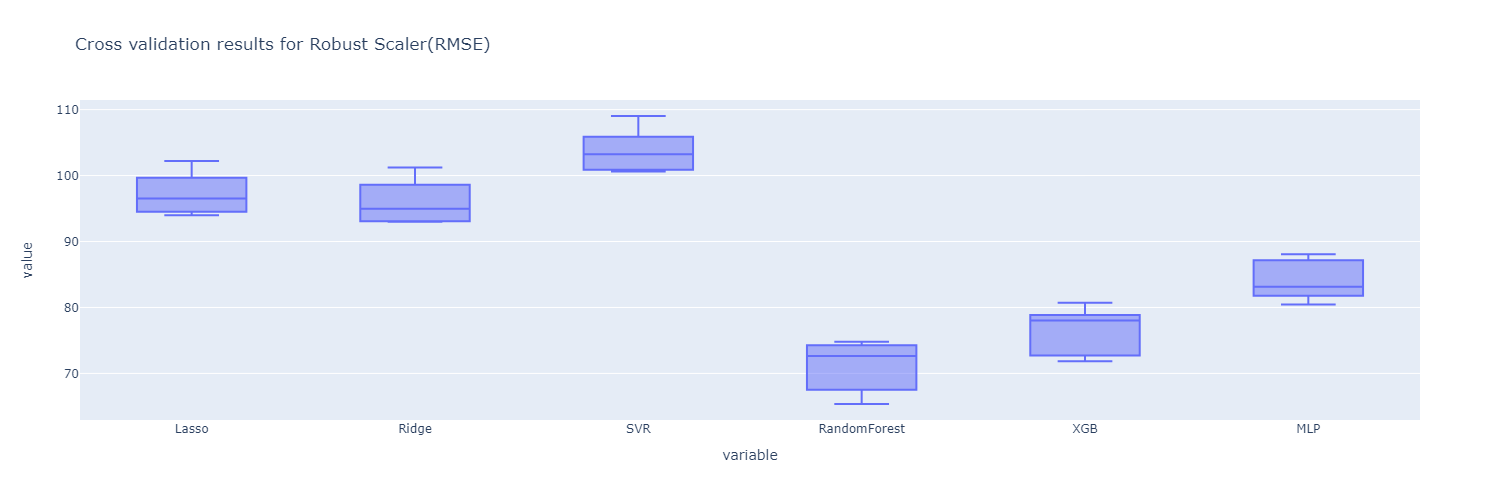

In [57]:
# Boxplot of the result for analisys of the algorithms, using Robust Scaler:

fig = px.box(result_rb_rmse, title="Cross validation results for Robust Scaler(RMSE)")
fig.show('png', width=1500, height=500)

In [58]:
# Models statistics for RMSE metric, using Rodbust Scaler:

result_rb_rmse.describe()

,Lasso,Ridge,SVR,RandomForest,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,97.249575,96.011658,103.731032,71.035363,76.378505,84.147928
std,3.342916,3.490900,3.424243,4.061271,3.768512,3.203008
min,93.990861,93.004625,100.607968,65.363863,71.859734,80.460837
25%,94.685013,93.107339,100.966472,68.269720,73.025233,82.223421
50%,96.529556,94.981097,103.237149,72.633881,78.034147,83.136099
75%,98.851141,97.734599,104.812319,74.121256,78.245726,86.835138
max,102.191306,101.230627,109.031253,74.788096,80.727684,88.084144


In [59]:
# Models statistics for R2 metric, using Rodbust Scaler:

result_rb_r2.describe()

,Lasso,Ridge,SVR,RandomForest,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.115711,0.138142,-0.006151,0.528083,0.454569,0.337918
std,0.007910,0.011422,0.007047,0.032785,0.027285,0.017129
min,0.106727,0.123443,-0.016853,0.499065,0.422993,0.312478
25%,0.109038,0.129051,-0.009913,0.500092,0.441765,0.336121
50%,0.117057,0.142447,-0.001660,0.521567,0.442556,0.336331
75%,0.119640,0.145157,-0.001285,0.542328,0.476347,0.345075
max,0.126095,0.150610,-0.001042,0.577362,0.489184,0.359584


Random Forest was the best algorithms while using the Robust Scaler.

- R2 score(mean): 0.528083
- Root mean squared error(mean): 71.035363

## 3) Tuning

As the boxplot has shown before, the best algorithms was Random Forest for all of the transformations. So now, we will tune some Random Forest models, with all of the transformations, using GridSearchCV.

In [60]:
# Function for tuning an arbitrary model:

def tuning(X_train, y_train, modelo, params):
    
    cv = 5
    score = "neg_root_mean_squared_error"
    grid  = GridSearchCV(modelo, cv=cv, param_grid=params, 
                         scoring=score, 
                         n_jobs=-1,
                         return_train_score=True,
                         )

    grid.fit(X_train, y_train)

    best_index = grid.best_index_
    result = grid.cv_results_

    train_score = -result['mean_train_score'][best_index]
    left_out = -result['mean_test_score'][best_index]



    print(f"Train score: {train_score}")
    print(f"Left out data score: {left_out}")

    return grid.best_estimator_

In [91]:
# Parameter grid:

params_grid = {
                "n_estimators":[310, 320, 330],
                "max_depth":[11, 12],
                "min_samples_split":[2, 5, 10],
                "max_features":[0.5, 0.6, 0.7]
}

3.1) MinMax Scaler

In [92]:
# Tuning a Random Forest using MinMax Scaler:

model_rnd = RandomForestRegressor(random_state=42)

print(f"Random Forest - MinMax Scaler:")
best_estimator_rnd_min_max = tuning(X_train_min_max, y_train, model_rnd, params_grid)

Random Forest - MinMax Scaler:
Train score: 55.12479891016886
Left out data score: 78.08350982452919


In [93]:
best_estimator_rnd_min_max

RandomForestRegressor(max_depth=12, max_features=0.5, n_estimators=330,
                      random_state=42)

3.2) Standard Scaler

In [94]:
# Tuning a Random Forest unsing Standard Scaler:

model_rnd = RandomForestRegressor(random_state=42)

print(f"Random Forest - Standard Scaler:")
best_estimator_rnd_std = tuning(X_train_std, y_train, model_rnd, params_grid)

Random Forest - Standard Scaler:
Train score: 55.12255345265335
Left out data score: 78.08603826317895


3.3) Robust Scaler

In [95]:
# Tuning a Random Forest using Robust Scaler:

model_rnd = RandomForestRegressor(random_state=42)

print(f"Random Forest - Robust Scaler:")
best_estimator_rnd_rb = tuning(X_train_rb, y_train, model_rnd, params_grid)

Random Forest - Robust Scaler:
Train score: 55.12750202432865
Left out data score: 78.09850053306779


Conclusions

- The best model was built using MinMax Scaler and Random Forest.
 
- Random Forest seem to suffer from Overfitting.

Train score: 55.12479891016886

Left out data score: 78.08350982452919

## 4) Predictions

In [96]:
# Clone the parameters of the best Random Forest model:

rd_best_model = clone(best_estimator_rnd_min_max)

In [97]:
# Training a Random Forest model:

rd_best_model.fit(X_train_min_max, y_train)

RandomForestRegressor(max_depth=12, max_features=0.5, n_estimators=330,
                      random_state=42)

In [98]:
# Predicting train set and test set:

y_pred_train = rd_best_model.predict(X_train_min_max)
y_pred_test = rd_best_model.predict(X_test_min_max)


# Calculating metrics for train set:

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

# Calculating metrics for test set:

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

In [99]:
# Train set results:

print("Train results:")
print(f"RMSE: {rmse_train}")
print(f"R2 score: {r2_train}")

Train results:
RMSE: 55.40548112965729
R2 score: 0.7131802255430152


In [100]:
# Test set results:

print("Test results:")
print(f"RMSE: {rmse_test}")
print(f"R2 score: {r2_test}")

Test results:
RMSE: 73.73601067684255
R2 score: 0.452680131272851
